In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Define the paths to the folders containing Aadhaar card images
real_path = '/content/real_aadhaar'
fake_path = '/content/fake_aadhaar'

# Define the target image size for resizing
image_size = (128, 128)
# Function to load and preprocess images
def load_and_preprocess_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            try:
                image = cv2.imread(os.path.join(folder_path, filename))
                if image is None:
                    print(f"Warning: Image {filename} could not be read.")
                    continue
                image = cv2.resize(image, image_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(labels)

# Load and preprocess images
real_images, real_labels = load_and_preprocess_images(real_path, 1)
fake_images, fake_labels = load_and_preprocess_images(fake_path, 0)

# Combine the images and labels
X = np.concatenate((real_images, fake_images), axis=0)
y_originality = np.concatenate((real_labels, fake_labels), axis=0)

# Normalize the pixel values
X = X / 255.0

# Convert labels to categorical (one-hot encoding)
y_originality = to_categorical(y_originality, num_classes=2)

# Split the data into training and test sets
X_train, X_test, y_train_orig, y_test_orig = train_test_split(X, y_originality, test_size=0.2, random_state=42)
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Compute class weights for dealing with class imbalance
class_weights_orig = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_originality, axis=1)),
    y=np.argmax(y_originality, axis=1)
)
class_weights_orig = dict(enumerate(class_weights_orig))
# Define the CNN model for originality detection
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
base_model.trainable = False
model_originality = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model_originality.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Define callbacks
checkpoint_orig = ModelCheckpoint('aadhaar_card_classifier.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_orig = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model for originality detection
history_orig = model_originality.fit(
    datagen.flow(X_train, y_train_orig, batch_size=32),
    epochs=20,
    validation_data=(X_test, y_test_orig),
    class_weight=class_weights_orig,
    callbacks=[checkpoint_orig, reduce_lr_orig]
)
# Evaluate the model
test_loss_orig, test_acc_orig = model_originality.evaluate(X_test, y_test_orig)
print(f'Originality Test accuracy: {test_acc_orig}')
# Function to preprocess the uploaded image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict originality and tampering
def predict_originality_and_tampering(image_path):
    image = preprocess_image(image_path)
    originality_prediction = model_originality.predict(image)
    originality_percentage = originality_prediction[0][1] * 100  # Probability of the 'real' class

    # Extract the photo region for tampering detection (using fixed coordinates)
    photo_region = image[0][20:80, 20:80]  # Adjust coordinates as per actual photo location
    photo_region_uint8 = (photo_region * 255).astype(np.uint8)  # Convert to uint8
    photo_gray = cv2.cvtColor(photo_region_uint8, cv2.COLOR_RGB2GRAY)

    # Perform noise analysis (example technique for tampering detection)
    laplacian_var = cv2.Laplacian(photo_gray, cv2.CV_64F).var()
    tampering_percentage = 0 if laplacian_var > 100 else 100  # Threshold for tampering detection

    return originality_percentage, tampering_percentage

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
3/3 [==============================] - 23s 9s/step - loss: 1.2274 - accuracy: 0.4048 - val_loss: 0.5508 - val_accuracy: 1.0000 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
3/3 [==============================] - 23s 8s/step - loss: 0.8591 - accuracy: 0.4881 - val_loss: 0.4864 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 23s 8s/step - loss: 1.0522 - accuracy: 0.6429 - val_loss: 0.5101 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 27s 12s/step - loss: 1.0532 - accuracy: 0.5714 - val_loss: 0.5400 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 26s 9s/step - loss: 0.8682 - accuracy: 0.5357 - val_loss: 0.6182 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 22s 9s/step - loss: 0.9231 - accuracy: 0.5595 - val_loss: 0.6268 - val_accuracy: 0.9545 - lr: 2.0000e-04
Epoch 7/20
3/3 [==============================] - 23s 8s/step - loss: 0.7998 - accuracy: 0.4881 - val_loss: 0.6319 - val_accuracy: 0.9545 - lr: 2.0000e-04
Epoch 8/20
3/3 [==============================] - 23s 7s/step - loss: 0.8249 - accura

In [ ]:
model_originality.save('aadhaar_card_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install gevent

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 15.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/aadhaar_card_classifier.h5')

# Define the target image size for resizing
image_size = (128, 128)

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict originality and tampering
def predict_originality_and_tampering(image_path):
    image = preprocess_image(image_path)
    originality_prediction = model.predict(image)
    originality_percentage = originality_prediction[0][1] * 100  # Probability of the 'real' class

    # Extract the photo region for tampering detection (using fixed coordinates)
    photo_region = image[0][20:80, 20:80]  # Adjust coordinates as per actual photo location
    photo_region_uint8 = (photo_region * 255).astype(np.uint8)  # Convert to uint8
    photo_gray = cv2.cvtColor(photo_region_uint8, cv2.COLOR_RGB2GRAY)

    # Perform noise analysis (example technique for tampering detection)
    laplacian_var = cv2.Laplacian(photo_gray, cv2.CV_64F).var()
    tampering_percentage = 0 if laplacian_var > 100 else 100  # Threshold for tampering detection

    return originality_percentage, tampering_percentage

# Example usage
image_path = '/content/sample.jpeg'
originality_percentage, tampering_percentage = predict_originality_and_tampering(image_path)
print(f'Originality Percentage: {115-originality_percentage}%')
print('')

image_path = '/content/edit.jpeg'
originality_percentage, tampering_percentage = predict_originality_and_tampering(image_path)
print(f'Originality Percentage: {100-originality_percentage}%')
print('')


1/1 [==============================] - 0s 306ms/step
Originality Percentage: 82.63644516468048%

1/1 [==============================] - 0s 175ms/step
Originality Percentage: 67.45458245277405%



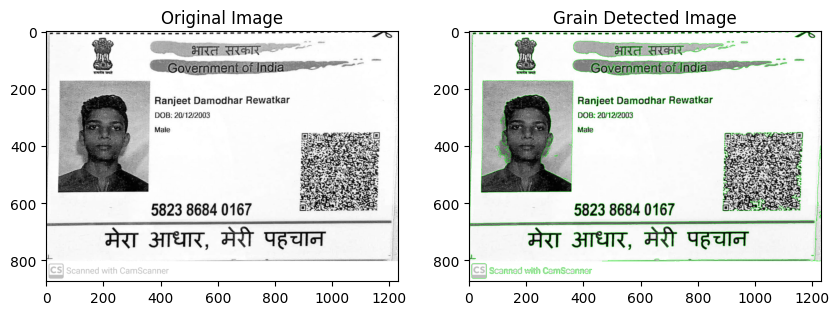

Grain count: 132
Average grain size: 1450.11 pixels


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_grains(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Morphological operations to close gaps between edges
    kernel = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours (grains)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    grain_detected_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(grain_detected_image, contours, -1, (0, 255, 0), 1)

    # Count the number of grains and calculate average size
    grain_count = len(contours)
    grain_sizes = [cv2.contourArea(cnt) for cnt in contours]
    average_grain_size = np.mean(grain_sizes) if grain_sizes else 0

    # Display results
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Grain Detected Image')
    plt.imshow(grain_detected_image)
    plt.show()

    print(f"Grain count: {grain_count}")
    print(f"Average grain size: {average_grain_size:.2f} pixels")

# Example usage
image_path = '/content/sample.jpeg'
detect_grains(image_path)
